In [11]:
import torch
import cv2
import torch.nn.functional as F
import matplotlib.pyplot as plt
from segment_anything.build_sam import build_siamese_sam
from segment_anything.dataloader import MedicalDataset
from segment_anything.utils import ContrasiveStructureLoss, LaplacianPyramid
from torchvision.transforms import transforms

In [12]:
sliceimg = 5
num_classes = 3
device = 'cuda'

In [13]:
test_CT = []
test_MRI = []

5
(256, 256)


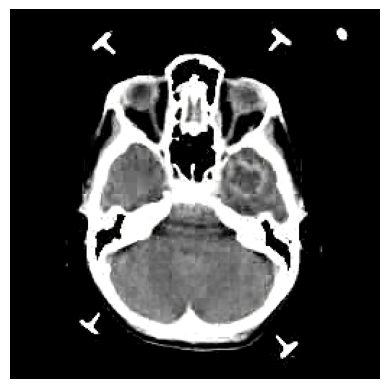

In [14]:
cap = cv2.VideoCapture('./dataset/Neoplastic_Disease/Metastatic_2/CT/spatial.mpg')
n = 0
while cap.isOpened():
    ret, frame = cap.read()
    n += 1
    if not ret or n == sliceimg:
        break
print(n)
CT = cap.read()[1]
plt.imshow(CT)
plt.axis('off')
CT = cv2.cvtColor(CT, cv2.COLOR_BGR2GRAY)
print(CT.shape)

5


(256, 256)


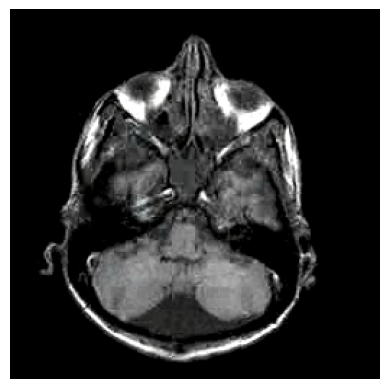

In [15]:
cap = cv2.VideoCapture('dataset/Inflammatory_or_Infectious_Disease/Cerebral_Toxoplasmosis/MR-T1/spatial (2).mpg')
n = 0
while cap.isOpened():
    ret, frame = cap.read()
    n += 1
    if not ret or n == sliceimg:
        break
print(n)
MRI = cap.read()[1]
plt.imshow(MRI)
plt.axis('off')
MRI = cv2.cvtColor(MRI, cv2.COLOR_BGR2GRAY)
print(MRI.shape)

(256, 256) (256, 256)


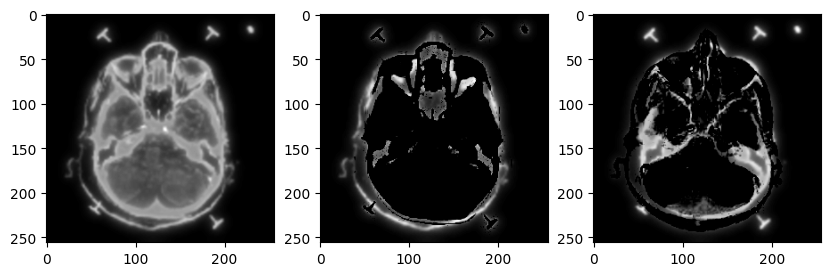

In [16]:
import cv2
import numpy as np

def build_laplacian_pyramid(image, levels):
    target_size = (256, 256)
    gaussian_pyramid = [image]
    for i in range(levels - 1):
        image = cv2.pyrDown(image)
        gaussian_pyramid.append(image)
    
    laplacian_pyramid = [gaussian_pyramid[levels - 1]]
    for i in range(levels - 1, 0, -1):
        expanded = cv2.pyrUp(gaussian_pyramid[i])
        laplacian = cv2.subtract(gaussian_pyramid[i - 1], expanded)
        laplacian_pyramid.append(laplacian)
        # print(cv2.resize(laplacian, target_size).shape)
    
    return laplacian_pyramid

def blend_images(image1, image2, levels):
    target_size = (256, 256)
    laplacian_pyramid1 = build_laplacian_pyramid(image1, levels)
    laplacian_pyramid2 = build_laplacian_pyramid(image2, levels)
    
    blended_pyramid = []
    for lap1, lap2 in zip(laplacian_pyramid1, laplacian_pyramid2):
        blended = np.where(np.abs(lap1) > np.abs(lap2), lap1, lap2)
        blended_pyramid.append(blended)
    
    blended_image = blended_pyramid[0]
    for i in range(1, levels - 1):
        blended_image = cv2.pyrUp(blended_image)
        blended_image = cv2.add(blended_pyramid[i], blended_image) // 2

    return blended_image
# 指定金字塔的级别数量
levels = 4

# 图像融合
blended_image = blend_images(CT, MRI, levels)
blended_image = cv2.pyrUp(blended_image)
print(blended_image.shape, CT.shape)
diff_CT = cv2.subtract(blended_image, CT)
diff_MRI = cv2.subtract(blended_image, MRI)


plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
plt.imshow(blended_image, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(diff_CT, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(diff_MRI, cmap='gray')

plt.show()
# 显示融合后的图像

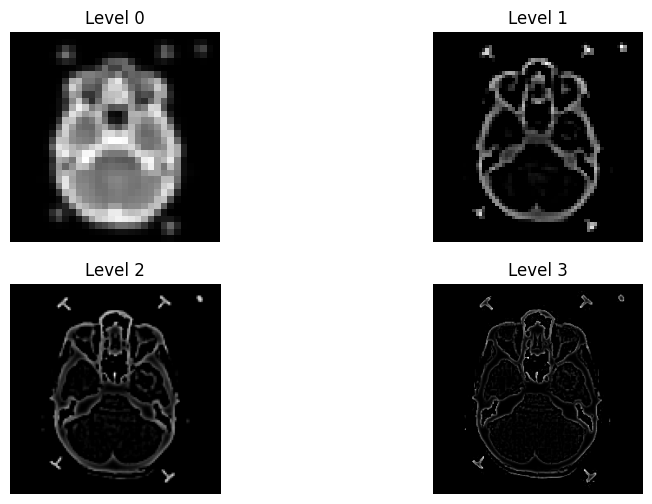

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def gaussian_laplacian_pyramid(image, levels):
    # 构建高斯金字塔
    gaussian_pyramid = [image]
    for i in range(levels - 1):
        image = cv2.pyrDown(image)
        gaussian_pyramid.append(image)
    
    # 构建拉普拉斯金字塔
    laplacian_pyramid = [gaussian_pyramid[levels - 1]]
    for i in range(levels - 1, 0, -1):
        gaussian_expanded = cv2.pyrUp(gaussian_pyramid[i])
        laplacian = cv2.subtract(gaussian_pyramid[i - 1], gaussian_expanded)
        laplacian_pyramid.append(laplacian)
    
    return gaussian_pyramid, laplacian_pyramid

# 构建高斯-拉普拉斯金字塔
levels = 4
gaussian_pyramid, pyramid = gaussian_laplacian_pyramid(CT, levels)

# 创建subplot并显示金字塔中的图像
plt.figure(figsize=(10, 6))
for i in range(levels):
    plt.subplot(2, levels // 2, i + 1)
    plt.imshow(pyramid[i], cmap='gray')
    plt.title(f'Level {i}')
    plt.axis('off')

plt.show()

(-0.5, 63.5, 63.5, -0.5)

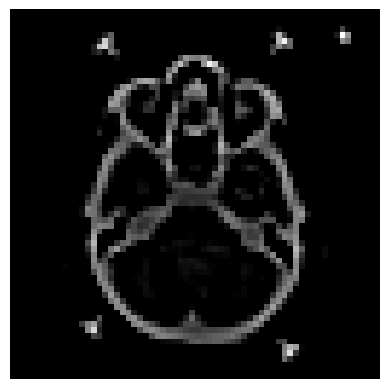

In [28]:
plt.imshow(pyramid[1], cmap='gray')
plt.axis('off')

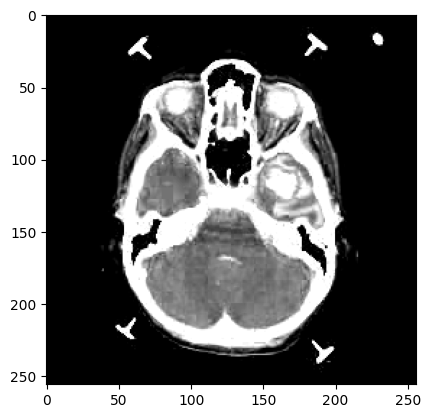

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# 确保两幅图像大小相同
MRI = cv2.resize(MRI, (CT.shape[1], CT.shape[0]))

# 求两幅图像的最大值
new_img = np.maximum(CT, MRI)

# 显示融合后的图像
plt.imshow(new_img, cmap='gray')
plt.show()


In [9]:
print(MRI.shape)

(256, 256)


In [10]:
PATH = 'model/best/SiameseSAM_epoch80_new.pth'
SiameseSAM = build_siamese_sam(num_classes=num_classes, checkpoint=None).to(device)
SiameseSAM.eval()
laplacian_pyramid = LaplacianPyramid(levels=4, device='cuda')

In [11]:
from thop import profile
inputs1 = torch.randn(1, 1, 256, 256).to(device)
inputs2 = torch.randn(1, 1, 256, 256).to(device)

# 计算FLOPs和参数量
flops, params = profile(SiameseSAM, inputs=([[inputs1, inputs2]]))
print(f'FLOPs: {flops}')
print(f'Number of parameters: {params}')

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv1d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.ConvTranspose2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_relu() for <class 'torch.nn.modules.activation.LeakyReLU'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register count_softmax() for <class 'torch.nn.modules.activation.Softmax'>.
FLOPs: 5471289833830.0
Number of parameters: 659910129.0


In [12]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((1024, 1024))
        ])
inputs = [transform(CT), transform(MRI)]
inputs = [i.to(device).unsqueeze(0) for i in inputs]
laplacian_CT, laplacian_MRI = laplacian_pyramid.build_laplacian_pyramid_CT(inputs[0]), laplacian_pyramid.build_laplacian_pyramid_MRI(inputs[1])
inputs = [inputs[0], inputs[1]]

/home/hansenfeng/anaconda3/envs/sam/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [13]:
output = SiameseSAM(inputs)
output[4] = laplacian_pyramid(output[4])

OutOfMemoryError: CUDA out of memory. Tried to allocate 80.00 MiB (GPU 0; 39.39 GiB total capacity; 35.58 GiB already allocated; 7.75 MiB free; 36.56 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
img = output[4][0].squeeze(0)

In [ ]:
print(img[120][170])

tensor(-0.2057, device='cuda:0', grad_fn=<SelectBackward0>)


(-0.5, 1023.5, 1023.5, -0.5)

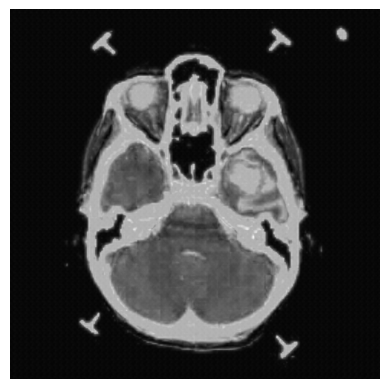

In [ ]:
plt.imshow(img.detach().cpu(), cmap='gray')
plt.axis('off')

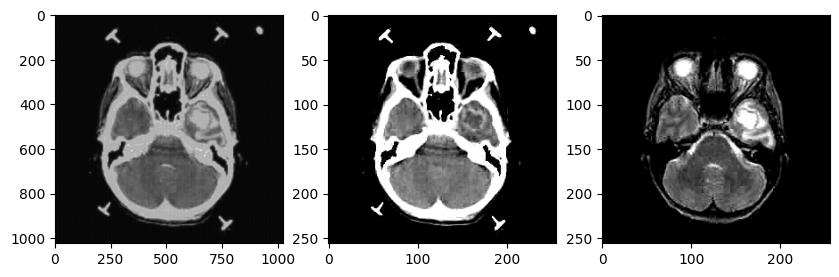

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
plt.imshow(img.detach().cpu(), cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(CT, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(MRI, cmap='gray')

In [ ]:
SSAM_output = []
for C, M, in zip(test_CT, test_MRI):
    transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((256, 256))
            ])
    inputs = [transform(CT), transform(MRI)]
    inputs = [i.to(device).unsqueeze(0) for i in inputs]
    laplacian_CT, laplacian_MRI = laplacian_pyramid.build_laplacian_pyramid_CT(inputs[0]), laplacian_pyramid.build_laplacian_pyramid_MRI(inputs[1])
    inputs = [laplacian_CT[0], laplacian_MRI[0]]
    output = SiameseSAM(inputs)
    output[4] = laplacian_pyramid(output[4])
    img = output[4][0].squeeze(0).cpu().detach().numpy()
    SSAM_output.append(img)

In [ ]:
import torch
import torch.nn.functional as F

# 定义 SSIM 损失函数
def ssim_loss(img1, img2, window_size=11, size_average=True):
    # 计算均值和方差
    mu1 = F.avg_pool2d(img1, window_size, stride=1, padding=0)
    mu2 = F.avg_pool2d(img2, window_size, stride=1, padding=0)
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    # 计算方差
    sigma1_sq = F.avg_pool2d(img1 ** 2, window_size, stride=1, padding=0) - mu1_sq
    sigma2_sq = F.avg_pool2d(img2 ** 2, window_size, stride=1, padding=0) - mu2_sq
    sigma12 = F.avg_pool2d(img1 * img2, window_size, stride=1, padding=0) - mu1_mu2

    # 计算 SSIM
    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return torch.mean(ssim_map)
    else:
        return ssim_map


loss = ssim_loss(torch.tensor(MRI).unsqueeze(0).float(), img.unsqueeze(0).float().cpu())
print(f"SSIM Loss: {loss.item()}")


RuntimeError: The size of tensor a (246) must match the size of tensor b (1014) at non-singleton dimension 2

In [ ]:
CT = cv2.resize(CT, (1024, 1024), interpolation=cv2.INTER_LINEAR)
MRI = cv2.resize(MRI, (1024, 1024), interpolation=cv2.INTER_LINEAR)

In [ ]:
import numpy as np
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import rank
from skimage.morphology import disk
from scipy.stats import entropy
from sewar.full_ref import vifp


def map_tensor_to_0_255(input_tensor):
    # 找到最小值和最大值
    min_val = torch.min(input_tensor)
    max_val = torch.max(input_tensor)
    
    # 归一化到 [0, 1]
    normalized_tensor = (input_tensor - min_val) / (max_val - min_val)
    
    # 映射到 [0, 255]
    mapped_tensor = normalized_tensor * 255.0
    
    # 将结果转换为 uint8 类型
    mapped_tensor = mapped_tensor.type(torch.uint8)
    
    return mapped_tensor


def calculate_entropy(image):
    if len(image.shape) == 3:
        image = rgb2gray(image)
    hist, _ = np.histogram(image, bins=256, range=(0, 255), density=True)
    return entropy(hist)


def calculate_standard_deviation(image):
    if len(image.shape) == 3:
        image = rgb2gray(image)
    image = np.array(image)
    return np.std(image)


def calculate_spatial_frequency(image):
    if len(image.shape) == 3:
        image = rgb2gray(image)
    M, N = image.shape
    RF = np.sqrt(np.sum(np.diff(image, axis=0)**2) / (M * N))
    CF = np.sqrt(np.sum(np.diff(image, axis=1)**2) / (M * N))
    return np.sqrt(RF**2 + CF**2)


def calculate_average_gradient(image):
    if len(image.shape) == 3:
        image = rgb2gray(image)
    gx, gy = np.gradient(image)
    return np.mean(np.sqrt(gx**2 + gy**2))


def calculate_scd(image1, image2):
    if len(image1.shape) == 3:
        image1 = rgb2gray(image1)
    if len(image2.shape) == 3:
        image2 = rgb2gray(image2)
    scd = np.sum((image1 - image2)**2) / np.sum(image1**2)
    return scd


def calculate_vif(image1, image2):
    if len(image1.shape) == 3:
        image1 = rgb2gray(image1)
    if len(image2.shape) == 3:
        image2 = rgb2gray(image2)
    return vifp(image1, image2)

# 示例用法
image = map_tensor_to_0_255(img.detach().cpu()).float()
en = calculate_entropy(image)
print("Entropy:", en)

sd = calculate_standard_deviation(image)
print("Standard Deviation:", sd)

sf = calculate_spatial_frequency(image)
print("Spatial Frequency:", sf)

ag = calculate_average_gradient(image)
print("Average Gradient:", ag)

scd = calculate_scd(image.numpy(), MRI.astype(np.float32))
print("Structure Content Dissimilarity:", scd)

vif = calculate_vif(image.numpy(), MRI.astype(np.float32))
print("Visual Information Fidelity:", vif)

Entropy: 3.661028878780254
Standard Deviation: 62.941288
Spatial Frequency: 5.263022574893664
Average Gradient: 2.4466975
Structure Content Dissimilarity: 0.48736864
Visual Information Fidelity: 0.16314489731594486


In [3]:
import torch
fc = torch.nn.Linear(64,4096)
print(fc.weight.shape)

torch.Size([4096, 64])
